Initialization and Importing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
#initialize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams.update({'font.size': 12})
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import math
import statsmodels.api as sm 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.datasets import make_classification

In [3]:
data = pd.read_csv('/content/drive/MyDrive/MIE1624/clean_kaggle_data_2022.csv', low_memory = False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Columns: 298 entries, Duration (in seconds) to Q29_buckets
dtypes: float64(1), object(297)
memory usage: 18.5+ MB


1. Data Cleaning

Keeping 5000 data points minimum per subset to have a robust dataset, or ~40% missing threshold based on question statement

In [4]:
missing = []
init_shape = data.shape[0]
threshold_remove = 1-(5000/init_shape)
for i in data.columns:
    nan_val = data[i].isna().sum()
    if nan_val >= threshold_remove*init_shape:
        missing.append(i)

print('These columns contained 38%+ of unfilled entries and will be dropped:', missing)

data.drop(missing, axis = 1, inplace = True)
print('Columns remained: ', data.shape[1])

These columns contained 38%+ of unfilled entries and will be dropped: ['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q6_7', 'Q6_8', 'Q6_9', 'Q6_10', 'Q6_11', 'Q6_12', 'Q7_1', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q7_7', 'Q10_1', 'Q10_2', 'Q10_3', 'Q12_2', 'Q12_3', 'Q12_4', 'Q12_5', 'Q12_6', 'Q12_7', 'Q12_8', 'Q12_9', 'Q12_10', 'Q12_11', 'Q12_12', 'Q12_13', 'Q12_14', 'Q12_15', 'Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q13_6', 'Q13_7', 'Q13_8', 'Q13_9', 'Q13_10', 'Q13_11', 'Q13_12', 'Q13_13', 'Q13_14', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q14_6', 'Q14_7', 'Q14_8', 'Q14_9', 'Q14_10', 'Q14_11', 'Q14_12', 'Q14_13', 'Q14_14', 'Q14_15', 'Q14_16', 'Q15_2', 'Q15_3', 'Q15_4', 'Q15_5', 'Q15_6', 'Q15_7', 'Q15_8', 'Q15_9', 'Q15_10', 'Q15_11', 'Q15_12', 'Q15_13', 'Q15_14', 'Q15_15', 'Q17_1', 'Q17_2', 'Q17_3', 'Q17_4', 'Q17_5', 'Q17_6', 'Q17_7', 'Q17_8', 'Q17_9', 'Q17_10', 'Q17_11', 'Q17_12', 'Q17_13', 'Q17_14', 'Q17_15', 'Q18_1', 'Q18_2', 'Q18_3', 'Q18_4', 'Q18_5', 'Q18_6', 'Q18_7', 'Q18_

Replace columns with 25% - ~40% of NaN with unknown

In [5]:
missing_rep = []
threshold_replace = 0.25

for i in data.columns:
    nan_val = data[i].isna().sum()
    if nan_val >= threshold_replace*init_shape and nan_val < threshold_remove*init_shape:
        missing_rep.append(i)

print("The following columns will have 'NaN' replaced with 'Unknown': ", missing_rep)

for i in missing_rep:
    data[i].fillna('Unknown', inplace = True)

The following columns will have 'NaN' replaced with 'Unknown':  ['Q7_2', 'Q9', 'Q15_1']


replace NaN values with mode if between 5 - 25%

In [6]:
missing_small = []
threshold_small = 0.05

for i in data.columns:
    nan_val = data[i].isnull().sum()
    if nan_val >= threshold_small*init_shape and nan_val < threshold_replace*init_shape:
        missing_small.append(i)

print("The following columns with have 'NaN' replaced with the data's mode: ", missing_small)

for i in missing_small:
    data[i].fillna(data[i].mode()[0], inplace = True)


The following columns with have 'NaN' replaced with the data's mode:  ['Q12_1', 'Q16']


Deleting rows if NaN % is less than 5% but greater than 0%. Data in this range and level of completeness indicate robust data and missing data should just be removed.

In [7]:
row_remove = []

for i in data.columns:
    nan_val = data[i].isnull().sum()
    if nan_val < threshold_small*init_shape and nan_val > 0:
        row_remove.append(i)

print("'NaN' in the following columns will be dropped: ", row_remove)

for i in row_remove:
    data.dropna(subset = [i], inplace = True)

print("Number of rows removed: ", init_shape - data.shape[0])
print("Total observations remaining: ", data.shape[0])


'NaN' in the following columns will be dropped:  ['Q30', 'Q29_Encoded', 'Q29_buckets']
Number of rows removed:  51
Total observations remaining:  8086


Dropping the duration column and Q29 as Q29_buckets and Q29_Encoded offer better information of the same category

In [8]:
data.drop(['Q29'], axis = 1, inplace = True)
data.drop(['Duration (in seconds)'], axis = 1, inplace = True)
print(data.shape)
data

(8086, 19)


,Q2,Q3,Q4,Q5,Q7_2,Q8,Q9,Q11,Q12_1,Q15_1,Q16,Q23,Q24,Q25,Q26,Q27,Q30,Q29_Encoded,Q29_buckets
1,55-59,Man,France,No,"Online courses (Coursera, EdX, etc)",Some college/university study without earning ...,Unknown,10-20 years,Python,Matplotlib,1-2 years,Data Scientist,Online Service/Internet-based Services,0-49 employees,1-2,"We recently started using ML methods (i.e., mo...","$1000-$9,999",2.0,"20,000-29,999"
2,30-34,Man,Germany,No,"Online courses (Coursera, EdX, etc)",Bachelor’s degree,Unknown,10-20 years,Python,Matplotlib,4-5 years,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...",$0 ($USD),10.0,"100,000-124,999"
3,70+,Man,Australia,No,Unknown,Doctoral degree,Yes,20+ years,Python,Unknown,5-10 years,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...",$100-$999,10.0,"100,000-124,999"
4,40-44,Man,United States of America,No,"Online courses (Coursera, EdX, etc)",Doctoral degree,Yes,10-20 years,Python,Unknown,5-10 years,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...",$100-$999,13.0,"200,000-299,999"
5,40-44,Man,United States of America,No,Unknown,Master’s degree,Yes,10-20 years,Python,Matplotlib,5-10 years,Data Scientist,Computers/Technology,"1000-9,999 employees",3-4,"We have well established ML methods (i.e., mod...","$100,000 or more ($USD)",13.0,"200,000-299,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,40-44,Man,United States of America,No,"Online courses (Coursera, EdX, etc)",Master’s degree,No,10-20 years,Python,Matplotlib,Under 1 year,Data Architect,Accounting/Finance,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...",$0 ($USD),10.0,"100,000-124,999"
8133,35-39,Man,India,No,"Online courses (Coursera, EdX, etc)",Master’s degree,No,1-3 years,Python,Matplotlib,1-2 years,Data Scientist,Broadcasting/Communications,"10,000 or more employees",1-2,"We have well established ML methods (i.e., mod...",$100-$999,0.0,"0-9,999"
8134,40-44,Man,India,No,"Online courses (Coursera, EdX, etc)",Bachelor’s degree,Unknown,1-3 years,Python,Matplotlib,I do not use machine learning methods,Data Engineer,Computers/Technology,0-49 employees,0,No (we do not use ML methods),$1-$99,0.0,"0-9,999"
8135,25-29,Man,Turkey,No,"Online courses (Coursera, EdX, etc)",Master’s degree,Yes,< 1 years,Python,Unknown,Under 1 year,Engineer (non-software),Energy/Mining,"10,000 or more employees",0,No (we do not use ML methods),$100-$999,2.0,"20,000-29,999"


Assigning proper column names

In [9]:
Salary = data
Salary.columns = ['Age', 'Gender', 'Country', 'Education Status', 'Useful Platform - Online Courses', 'Education Level', 'Academic Publications', 'Coding Experience', 
'Main Programming Language', 'Data Visualization', 'ML_Experience', 'Job Title', 'Industry', 'Company Size', 'Data Scientists in Business', 'ML Incorporation', 
'Money spent on ML/Cloud Computing', 'Salary_Encoded', 'Salary_buckets']
Salary

,Age,Gender,Country,Education Status,Useful Platform - Online Courses,Education Level,Academic Publications,Coding Experience,Main Programming Language,Data Visualization,ML_Experience,Job Title,Industry,Company Size,Data Scientists in Business,ML Incorporation,Money spent on ML/Cloud Computing,Salary_Encoded,Salary_buckets
1,55-59,Man,France,No,"Online courses (Coursera, EdX, etc)",Some college/university study without earning ...,Unknown,10-20 years,Python,Matplotlib,1-2 years,Data Scientist,Online Service/Internet-based Services,0-49 employees,1-2,"We recently started using ML methods (i.e., mo...","$1000-$9,999",2.0,"20,000-29,999"
2,30-34,Man,Germany,No,"Online courses (Coursera, EdX, etc)",Bachelor’s degree,Unknown,10-20 years,Python,Matplotlib,4-5 years,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...",$0 ($USD),10.0,"100,000-124,999"
3,70+,Man,Australia,No,Unknown,Doctoral degree,Yes,20+ years,Python,Unknown,5-10 years,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...",$100-$999,10.0,"100,000-124,999"
4,40-44,Man,United States of America,No,"Online courses (Coursera, EdX, etc)",Doctoral degree,Yes,10-20 years,Python,Unknown,5-10 years,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...",$100-$999,13.0,"200,000-299,999"
5,40-44,Man,United States of America,No,Unknown,Master’s degree,Yes,10-20 years,Python,Matplotlib,5-10 years,Data Scientist,Computers/Technology,"1000-9,999 employees",3-4,"We have well established ML methods (i.e., mod...","$100,000 or more ($USD)",13.0,"200,000-299,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,40-44,Man,United States of America,No,"Online courses (Coursera, EdX, etc)",Master’s degree,No,10-20 years,Python,Matplotlib,Under 1 year,Data Architect,Accounting/Finance,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...",$0 ($USD),10.0,"100,000-124,999"
8133,35-39,Man,India,No,"Online courses (Coursera, EdX, etc)",Master’s degree,No,1-3 years,Python,Matplotlib,1-2 years,Data Scientist,Broadcasting/Communications,"10,000 or more employees",1-2,"We have well established ML methods (i.e., mod...",$100-$999,0.0,"0-9,999"
8134,40-44,Man,India,No,"Online courses (Coursera, EdX, etc)",Bachelor’s degree,Unknown,1-3 years,Python,Matplotlib,I do not use machine learning methods,Data Engineer,Computers/Technology,0-49 employees,0,No (we do not use ML methods),$1-$99,0.0,"0-9,999"
8135,25-29,Man,Turkey,No,"Online courses (Coursera, EdX, etc)",Master’s degree,Yes,< 1 years,Python,Unknown,Under 1 year,Engineer (non-software),Energy/Mining,"10,000 or more employees",0,No (we do not use ML methods),$100-$999,2.0,"20,000-29,999"


Checking columns for > 1 unique value and not unknown

In [10]:
for col in data:
    print(col, data[col].unique())

Age ['55-59' '30-34' '70+' '40-44' '50-54' '25-29' '60-69' '35-39' '22-24'
 '45-49' '18-21']
Gender ['Man' 'Woman' 'Prefer not to say' 'Prefer to self-describe' 'Nonbinary']
Country ['France' 'Germany' 'Australia' 'United States of America' 'Singapore'
 'Italy' 'Taiwan' 'Brazil' 'Argentina' 'Chile' 'Other' 'Japan' 'Canada'
 'Indonesia' 'India' 'Colombia' 'Pakistan' 'Mexico' 'Turkey' 'Spain'
 'Cameroon' 'Nigeria'
 'United Kingdom of Great Britain and Northern Ireland' 'Ethiopia'
 'Tunisia' 'Philippines' 'Egypt' 'South Korea' 'Peru' 'Thailand'
 'Iran, Islamic Republic of...' 'Netherlands' 'Ghana' 'Portugal' 'Russia'
 'Viet Nam' 'Poland' 'Saudi Arabia' 'Bangladesh' 'Czech Republic' 'Israel'
 'China' 'Sri Lanka' 'South Africa' 'Hong Kong (S.A.R.)' 'Kenya' 'Romania'
 'Morocco' 'Ukraine' 'United Arab Emirates' 'Nepal' 'Belgium' 'Malaysia'
 'Ecuador' 'I do not wish to disclose my location' 'Algeria' 'Zimbabwe'
 'Ireland']
Education Status ['No']
Useful Platform - Online Courses ['Online cours

In [11]:
#dropping Education status and Main programming language as they are single-valued columns that do not represent useful data
data.drop(['Education Status', 'Main Programming Language', 'Useful Platform - Online Courses'], axis=1, inplace=True)

2. Exploratory Data Analysis

In [12]:
buckets = ['$0-9,999','$10,000-19,999','$20,000-29,999','$30,000-39,999',
           '$40,000-49,999','$50,000-59,999','$60,000-69,999',
           '$70,000-79,999','$80,000-89,999','$90,000-99,999',
            '$100,000-124,999','125,000-149,999','$150,000-199,999',
            '$200,000-299,999','$> 300,000'
           ]

In [13]:
sns.set(rc={'figure.figsize':(8,8), 'figure.facecolor':'white' })

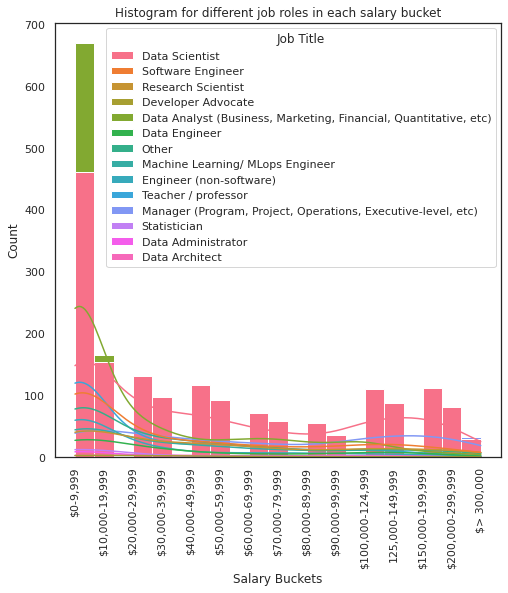

In [14]:
sns.set(rc={'figure.figsize':(8,8), 'figure.facecolor':'white' })
sns.set_style('white')
sns.histplot(x=Salary.iloc[1:,:].Salary_Encoded,hue=Salary['Job Title'],kde=True, alpha=1)
plt.xticks(range(15),buckets)
plt.xticks(rotation=90)
plt.title('Histogram for different job roles in each salary bucket')
plt.xlabel('Salary Buckets')
plt.show()

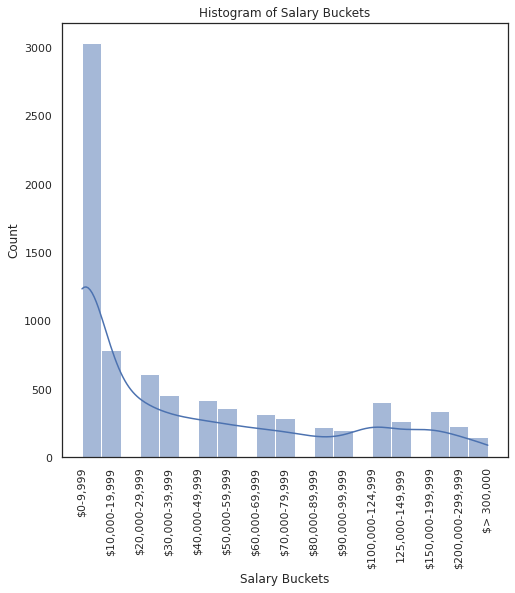

In [15]:
sns.set(rc={'figure.figsize':(8,8), 'figure.facecolor':'white' } )
sns.set_style('white')
sns.histplot(data=Salary.Salary_buckets.value_counts(),x=Salary.Salary_Encoded,hue_order=buckets ,kde=True)
plt.title('Histogram of Salary Buckets')
plt.xticks(range(15),buckets)
plt.xticks(rotation=90)
plt.xlabel('Salary Buckets')
plt.show()

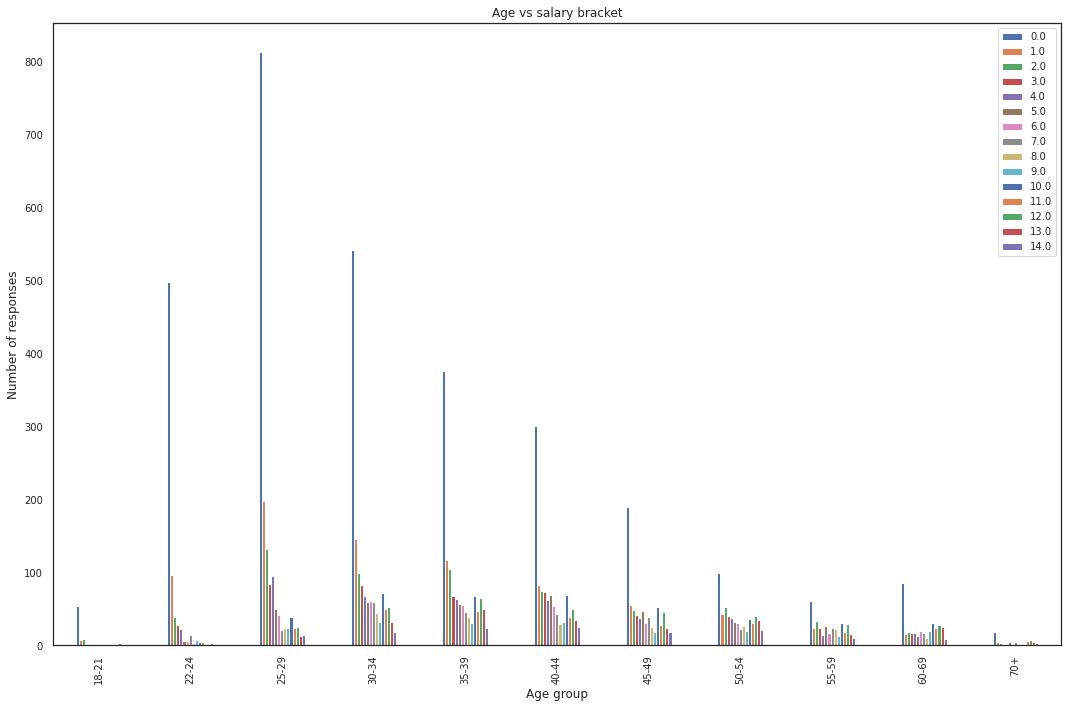

In [16]:
df_sal_age = Salary.groupby(['Salary_Encoded','Age']).size().reset_index().pivot(columns='Salary_Encoded', index='Age', values=0)
ax = df_sal_age.plot(kind='bar',figsize=(15,10))
ax.set_xlabel('Age group')
ax.set_ylabel('Number of responses')
ax.tick_params(labelsize=10)
plt.title('Age vs salary bracket')
plt.legend(loc=1, prop={'size': 10})
plt.tight_layout()
plt.show()

Providing categorical data some type of numerical score for the heat map

In [17]:
sal_features = Salary.copy()

#ml exp
def exp_1 (value):
    mapdict = {'I do not use machine learning methods': -1, 'Under 1 year': 0, '1-2 years': 1.5, '2-3 years': 2.5, '3-4 years': 3.5, '4-5 years': 4.5, 
                '5-10 years': 7.5, '10-20 years': 15, '20+ years': 20}
    return mapdict[value]

#code exp
def exp_2 (value):
    mapdict = {'I have never written code': -1, '< 1 years': 0, '1-3 years': 2, '3-5 years': 4, '5-10 years': 7.5, '10-20 years': 15, '20+ years': 20}
    return mapdict[value]

#money spent
def exp_3 (value):
    mapdict = {'$0 ($USD)': 0, '$1-$99': 1, '$100-$999': 2, '$1000-$9,999': 3, '$10,000-$99,999': 4, '$100,000 or more ($USD)': 5}
    return mapdict[value]

#education
def exp_4 (value):
    mapdict = {'I prefer not to answer': 0, 'No formal education past high school': 1, 'Some college/university study without earning a bachelor’s degree': 2,
               'Bachelor’s degree': 3,'Professional degree': 4, 'Master’s degree': 5, 'Doctoral degree': 6, 'Professional doctorate': 7}
    return mapdict[value]


Encoding is done here

In [18]:
labelencoder = LabelEncoder()

Salary_F = Salary.copy()

#dropping salary_buckets for heatmap 
Salary_F.drop(['Salary_buckets'], axis=1, inplace=True)

for col in Salary_F.columns:
    Salary_F[col] = labelencoder.fit_transform(Salary_F[col])

Salary_F['ML_Experience'] = sal_features['ML_Experience'].apply(exp_1)
Salary_F['Coding Experience'] = sal_features['Coding Experience'].apply(exp_2)
Salary_F['Money spent on ML/Cloud Computing'] = sal_features['Money spent on ML/Cloud Computing'].apply(exp_3)
Salary_F['Education Level'] = sal_features['Education Level'].apply(exp_4)


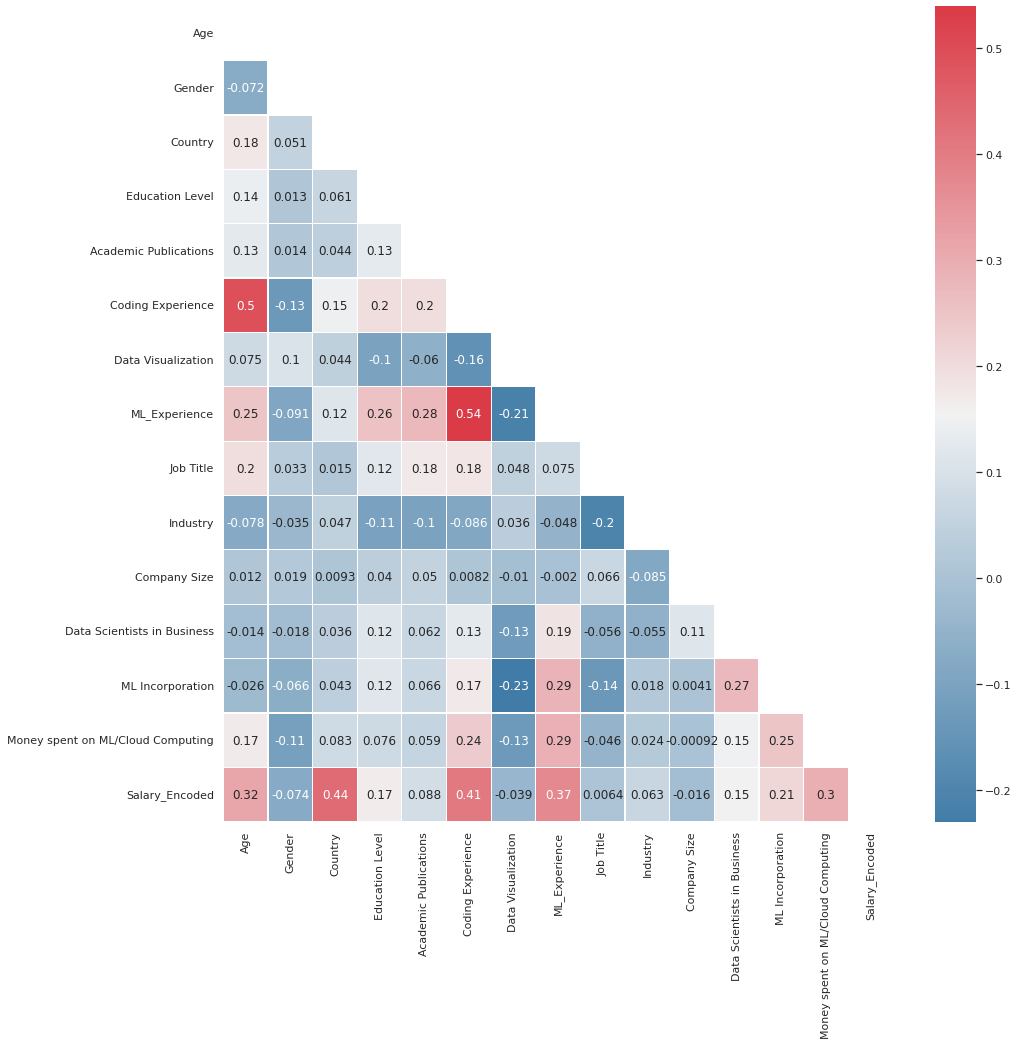

In [19]:
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(Salary_F.corr(method = 'pearson'), dtype=bool))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
fig = sns.heatmap(Salary_F.corr(method = 'pearson'), mask = mask, annot = True, cmap = cmap, linewidths = 0.2)

Top 5 most important features related to 'Salary_encoded':
1. Country (p = 0.44)
2. Coding Experience (p = 0.41)
3. ML_Experience (p = 0.37)
4. Age (p = 0.32)
5. Money Spent on ML/Cloud Computing (p = 0.3)

Top 5 least important features related to 'Salary_encoded':
1. gender (p = -0.074)
2. Data Visualization (-0.039)
3. Company Size (-0.016)
4. Job Title (0.0064)
5. Academic Publications (0.088)

Given Salary_Encoded represents the respondent's yearly compensation, the above stated top 5 features are the most related.

Feature Selection - L1 Regularized Regression or Lasso Regression

In [20]:
L_Salary = Salary_F.copy()

y = L_Salary['Salary_Encoded']
L_Salary.drop(['Salary_Encoded'], axis=1, inplace = True)
X = L_Salary

#for this file, random state = 19 will be the basis of the train_test_split value generation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=19, shuffle=True)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)

#alpha at 0.1 which retains 12/14 values
reg = Lasso(alpha = 0.1,max_iter=10000)
reg.fit(X_train, y_train)
reg.score(X_train, y_train)
print("Alpha = 0.1: ",list(zip(reg.coef_, X)))

#increased alpha to 0.2, retaining 9/14 values
reg = linear_model.Lasso(alpha = 0.2,max_iter=10000)
reg.fit(X_train, y_train)
reg.score(X_train, y_train)
print("Alpha = 0.3: ",list(zip(reg.coef_, X)))


Alpha = 0.1:  [(0.426963585266024, 'Age'), (-0.02549639003194517, 'Gender'), (1.4625817439428874, 'Country'), (0.11556011978901978, 'Education Level'), (-0.012399938224260889, 'Academic Publications'), (0.7488586315078241, 'Coding Experience'), (0.0, 'Data Visualization'), (0.5993959850751349, 'ML_Experience'), (-0.048571317261180316, 'Job Title'), (0.23131656277249604, 'Industry'), (-0.0, 'Company Size'), (0.11554936689780784, 'Data Scientists in Business'), (0.272651835787593, 'ML Incorporation'), (0.5190983473054138, 'Money spent on ML/Cloud Computing')]
Alpha = 0.3:  [(0.35015958401140856, 'Age'), (-0.0, 'Gender'), (1.3970479769027837, 'Country'), (0.03594359705697657, 'Education Level'), (-0.0, 'Academic Publications'), (0.7278312852009331, 'Coding Experience'), (0.0, 'Data Visualization'), (0.5851286138271724, 'ML_Experience'), (-0.0, 'Job Title'), (0.12736599843000815, 'Industry'), (-0.0, 'Company Size'), (0.04377245696753069, 'Data Scientists in Business'), (0.22877809034270727

All categories with 0 as the coefficient shall be removed by L1 regression definition

Feature Selection - Recursive Feature Elimination (RFE)

In [21]:
L_Salary = Salary_F.copy()

y = L_Salary['Salary_Encoded']
L_Salary.drop(['Salary_Encoded'], axis=1, inplace = True)
X = L_Salary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=19, shuffle=True)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)

LR = LogisticRegression()
rfe = RFE(LR, n_features_to_select = 9)
rfe_fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))
RFE_val = X.columns[(rfe_fit.support_)]
print(RFE_val)

Num Features: 9
Selected Features: [ True False  True False False  True  True  True False  True False  True
  True  True]
Feature Ranking: [1 5 1 3 4 1 1 1 6 1 2 1 1 1]
Index(['Age', 'Country', 'Coding Experience', 'Data Visualization',
       'ML_Experience', 'Industry', 'Data Scientists in Business',
       'ML Incorporation', 'Money spent on ML/Cloud Computing'],
      dtype='object')


L1 regression and RFE have identical results when n = 9, RFE ranks the top 9 attributes as 1.

Applying the feature selection (RFE) to encoded dataset

In [22]:
selected_var = Salary_F.copy()

#dropping all columns removed by RFE/lasso regression
drop = ['Job Title', 'Gender', 'Academic Publications', 'Data Visualization', 'Company Size']

for i in drop:
    selected_var.drop([i], axis = 1, inplace = True)

selected_var

,Age,Country,Education Level,Coding Experience,ML_Experience,Industry,Data Scientists in Business,ML Incorporation,Money spent on ML/Cloud Computing,Salary_Encoded
1,8,15,2,15.0,1.5,11,1,4,3,2
2,3,16,3,15.0,4.5,6,4,3,0,10
3,10,2,6,20.0,7.5,5,4,4,2,10
4,5,55,6,15.0,7.5,3,4,3,2,13
5,5,55,5,15.0,7.5,3,5,3,5,13
...,...,...,...,...,...,...,...,...,...,...
8132,5,55,5,15.0,0.0,1,4,3,0,10
8133,4,20,5,2.0,1.5,2,1,3,2,0
8134,5,20,3,2.0,-1.0,3,0,1,1,0
8135,2,51,5,0.0,0.0,4,0,1,2,2


3. Model Implementation

OLR

To keep the following process clean

In [23]:
import warnings
warnings.filterwarnings("ignore")

Implementing 14 logistic regression models (15-1 salary buckets [features] available)

Creating a specific dataset from the main dataset as a binary classsifer for each logistic regression model

In [24]:
df01 = selected_var.copy()

for row in range(0, 8086):
        if (selected_var['Salary_Encoded'].iloc[row]>=1):
            df01['Salary_Encoded'].iloc[row] = 1
        else:
            df01['Salary_Encoded'].iloc[row] = 0


In [25]:
df12 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=2):
        df12['Salary_Encoded'].iloc[row] = 1
    else:
        df12['Salary_Encoded'].iloc[row] = 0

In [26]:
df23 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=3):
        df23['Salary_Encoded'].iloc[row] = 1
    else:
        df23['Salary_Encoded'].iloc[row] = 0

In [27]:
df34 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=4):
        df34['Salary_Encoded'].iloc[row] = 1
    else:
        df34['Salary_Encoded'].iloc[row] = 0

In [28]:
df45 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=5):
        df45['Salary_Encoded'].iloc[row] = 1
    else:
        df45['Salary_Encoded'].iloc[row] = 0

In [29]:
df56 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=6):
        df56['Salary_Encoded'].iloc[row] = 1
    else:
        df56['Salary_Encoded'].iloc[row] = 0

In [30]:
df67 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=7):
        df67['Salary_Encoded'].iloc[row] = 1
    else:
        df67['Salary_Encoded'].iloc[row] = 0

In [31]:
df78 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=8):
        df78['Salary_Encoded'].iloc[row] = 1
    else:
        df78['Salary_Encoded'].iloc[row] = 0

In [32]:
df89 = selected_var.copy()


for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=9):
        df89['Salary_Encoded'].iloc[row] = 1
    else:
        df89['Salary_Encoded'].iloc[row] = 0

In [33]:
df910 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=10):
        df910['Salary_Encoded'].iloc[row] = 1
    else:
        df910['Salary_Encoded'].iloc[row] = 0

In [34]:
df1011 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=11):
        df1011['Salary_Encoded'].iloc[row] = 1
    else:
        df1011['Salary_Encoded'].iloc[row] = 0

In [35]:
df1112 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=12):
        df1112['Salary_Encoded'].iloc[row] = 1
    else:
        df1112['Salary_Encoded'].iloc[row] = 0

In [36]:
df1213 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=13):
        df1213['Salary_Encoded'].iloc[row] = 1
    else:
        df1213['Salary_Encoded'].iloc[row] = 0

In [37]:
df1314 = selected_var.copy()

for row in range(0, 8086):
    if (selected_var['Salary_Encoded'].iloc[row]>=14):
        df1314['Salary_Encoded'].iloc[row] = 1
    else:
        df1314['Salary_Encoded'].iloc[row] = 0

Scaling/normalization of the data is not necessary because each logistic regression model has been modified into a binary classifier. Additionally, each category represented in X is already encoded and thus does not make sense to scale the data (i.e. "get_dummies" can split the encoded data to 1-hot encoded data).

To supress some outputs when doing hyperparameter tuning

In [38]:
import sys, os

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

declaring k-fold function for cross validation

In [39]:
def kfold_fn(X_t,y_t, lgr):

       
    kf = KFold(n_splits=10, shuffle = False)
    kf.get_n_splits(X_t)

    accuracy = np.zeros(10)
    idx = 0
    bias_3 = np.zeros(10)
    variance_3 = np.zeros(10)
    MSE = np.zeros(10)

    for train_index, test_index in kf.split(X_t):
        X_train = X_t.values[train_index]
        y_train = y_t.values[train_index]

        lgr.fit(X_train, y_train)

        predictions = lgr.predict(X_train)
        ACC = lgr.score(X_train, y_train)
        accuracy[idx] = ACC*100
        MSE[idx] = mean_squared_error(y_train, predictions)
        idx += 1

        avg = round(np.mean(accuracy),3)
        std = round(np.std(accuracy),3)
        bias = round(np.mean(MSE),4)
        var = round(np.std(MSE),4)

        # bias is defined as the mean of the errors and variance is defined as the standard deviation of the errors

        print ("Fold {}: Accuracy: {}%".format(idx, round(ACC*100,3)))   

    print("\nAverage Score: {}%".format(avg))
    print("Standard deviation: {}".format(std))
    print("\nBias of the model: {}".format(bias))
    print("Variance of the model: {}".format(var))

    return avg, std, bias, var

Single hyperparameter tuning of regularization parameter "C"

In [40]:
def C_tune (X_t, y_t):    
    param_list = [1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1, 5, 10, 100, 1000]

    tuned_avg = np.zeros(len(param_list))
    tuned_std = np.zeros(len(param_list))
    tuned_bias = np.zeros(len(param_list))
    tuned_var = np.zeros(len(param_list))
    count = 0
    for param in param_list:
        model = LogisticRegression(C = param, solver = 'newton-cg', penalty = 'l2')
        with HiddenPrints():
            tuned_avg[count], tuned_std[count], tuned_bias[count], tuned_var[count] = kfold_fn(X_t, y_t, model)
        count += 1

        #print("C:", param, ", Score: " + str(round(model.score(X_t, y_t)*100, 3)) + "%")
    C_val = pd.DataFrame(index = param_list, columns = ['avg', 'std', 'bias', 'var'])
    C_val['avg'] = tuned_avg
    C_val['std'] = tuned_std
    C_val['bias'] = tuned_bias
    C_val['var'] = tuned_var
    return C_val


Performing 10-fold validation and hyperparameter tuning on each of the 14 regression models and their respective dataset

In [41]:
Y01 = df01['Salary_Encoded']
df01.drop(['Salary_Encoded'], axis = 1, inplace = True)
X01 = df01

In [42]:
X_train01, X_test01, y_train01, y_test_01 = train_test_split(X01, Y01,  test_size = 0.33, random_state= 1)

lgr01 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')  

kfold_fn(X_train01,y_train01, lgr01)
C_tune(X_train01, y_train01)

Fold 1: Accuracy: 73.19%
Fold 2: Accuracy: 73.169%
Fold 3: Accuracy: 72.903%
Fold 4: Accuracy: 73.149%
Fold 5: Accuracy: 73.231%
Fold 6: Accuracy: 72.841%
Fold 7: Accuracy: 72.923%
Fold 8: Accuracy: 72.744%
Fold 9: Accuracy: 73.339%
Fold 10: Accuracy: 72.416%

Average Score: 72.99%
Standard deviation: 0.265

Bias of the model: 0.2701
Variance of the model: 0.0026


,avg,std,bias,var
0.0001,72.110,0.174,0.2789,0.0017
0.0010,73.390,0.222,0.2661,0.0022
0.0100,73.052,0.239,0.2695,0.0024
0.1000,73.011,0.273,0.2699,0.0027
0.5000,72.992,0.263,0.2701,0.0026
1.0000,72.990,0.265,0.2701,0.0026
5.0000,72.992,0.266,0.2701,0.0027
10.0000,72.990,0.271,0.2701,0.0027
100.0000,72.990,0.271,0.2701,0.0027
1000.0000,72.990,0.271,0.2701,0.0027


In [43]:
Y12 = df12['Salary_Encoded']
df12.drop(['Salary_Encoded'], axis = 1, inplace = True)
X12 = df12

In [44]:
X_train12, X_test12, y_train12, y_test_12 = train_test_split(X12, Y12,  test_size = 0.33, random_state= 1)

lgr12 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train12,y_train12, lgr12)
C_tune(X_train12, y_train12)

Fold 1: Accuracy: 73.621%
Fold 2: Accuracy: 74.154%
Fold 3: Accuracy: 73.723%
Fold 4: Accuracy: 73.621%
Fold 5: Accuracy: 73.764%
Fold 6: Accuracy: 74.051%
Fold 7: Accuracy: 73.662%
Fold 8: Accuracy: 73.831%
Fold 9: Accuracy: 73.831%
Fold 10: Accuracy: 73.852%

Average Score: 73.811%
Standard deviation: 0.168

Bias of the model: 0.2619
Variance of the model: 0.0017


,avg,std,bias,var
0.0001,73.614,0.193,0.2639,0.0019
0.0010,73.755,0.246,0.2624,0.0025
0.0100,73.864,0.230,0.2614,0.0023
0.1000,73.821,0.184,0.2618,0.0018
0.5000,73.817,0.170,0.2618,0.0017
1.0000,73.811,0.168,0.2619,0.0017
5.0000,73.811,0.168,0.2619,0.0017
10.0000,73.811,0.168,0.2619,0.0017
100.0000,73.811,0.168,0.2619,0.0017
1000.0000,73.811,0.168,0.2619,0.0017


In [45]:
Y23 = df23['Salary_Encoded']
df23.drop(['Salary_Encoded'], axis = 1, inplace = True)
X23 = df23

In [46]:
X_train23, X_test23, y_train23, y_test_23 = train_test_split(X23, Y23,  test_size = 0.33, random_state= 1)

lgr23 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train23,y_train23, lgr23)

C_tune(X_train23, y_train23)

Fold 1: Accuracy: 74.338%
Fold 2: Accuracy: 74.851%
Fold 3: Accuracy: 74.585%
Fold 4: Accuracy: 74.605%
Fold 5: Accuracy: 74.503%
Fold 6: Accuracy: 75.2%
Fold 7: Accuracy: 74.4%
Fold 8: Accuracy: 74.672%
Fold 9: Accuracy: 74.159%
Fold 10: Accuracy: 75.082%

Average Score: 74.64%
Standard deviation: 0.309

Bias of the model: 0.2536
Variance of the model: 0.0031


,avg,std,bias,var
0.0001,74.480,0.240,0.2552,0.0024
0.0010,74.779,0.315,0.2522,0.0032
0.0100,74.705,0.288,0.2529,0.0029
0.1000,74.652,0.314,0.2535,0.0031
0.5000,74.644,0.305,0.2536,0.0031
1.0000,74.640,0.309,0.2536,0.0031
5.0000,74.642,0.310,0.2536,0.0031
10.0000,74.642,0.310,0.2536,0.0031
100.0000,74.642,0.310,0.2536,0.0031
1000.0000,74.642,0.310,0.2536,0.0031


In [47]:
Y34 = df34['Salary_Encoded']
df34.drop(['Salary_Encoded'], axis = 1, inplace = True)
X34 = df34

In [48]:
X_train34, X_test34, y_train34, y_test_34 = train_test_split(X34, Y34,  test_size = 0.33, random_state= 1)

lgr34 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train34,y_train34, lgr34)

C_tune(X_train34, y_train34)

Fold 1: Accuracy: 74.995%
Fold 2: Accuracy: 75.405%
Fold 3: Accuracy: 75.303%
Fold 4: Accuracy: 75.385%
Fold 5: Accuracy: 75.487%
Fold 6: Accuracy: 75.774%
Fold 7: Accuracy: 75.2%
Fold 8: Accuracy: 75.349%
Fold 9: Accuracy: 74.877%
Fold 10: Accuracy: 75.841%

Average Score: 75.362%
Standard deviation: 0.286

Bias of the model: 0.2464
Variance of the model: 0.0029


,avg,std,bias,var
0.0001,75.210,0.308,0.2479,0.0031
0.0010,75.686,0.288,0.2431,0.0029
0.0100,75.431,0.291,0.2457,0.0029
0.1000,75.366,0.283,0.2463,0.0028
0.5000,75.359,0.285,0.2464,0.0029
1.0000,75.362,0.286,0.2464,0.0029
5.0000,75.362,0.286,0.2464,0.0029
10.0000,75.362,0.286,0.2464,0.0029
100.0000,75.362,0.286,0.2464,0.0029
1000.0000,75.362,0.286,0.2464,0.0029


In [49]:
Y45 = df45['Salary_Encoded']
df45.drop(['Salary_Encoded'], axis = 1, inplace = True)
X45 = df45

In [50]:
X_train45, X_test45, y_train45, y_test_45 = train_test_split(X45, Y45,  test_size = 0.33, random_state= 1)

lgr45 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train45,y_train45, lgr45)

C_tune(X_train45, y_train45)

Fold 1: Accuracy: 77.6%
Fold 2: Accuracy: 77.374%
Fold 3: Accuracy: 77.251%
Fold 4: Accuracy: 77.579%
Fold 5: Accuracy: 77.456%
Fold 6: Accuracy: 77.805%
Fold 7: Accuracy: 77.559%
Fold 8: Accuracy: 77.933%
Fold 9: Accuracy: 77.358%
Fold 10: Accuracy: 77.851%

Average Score: 77.577%
Standard deviation: 0.215

Bias of the model: 0.2242
Variance of the model: 0.0022


,avg,std,bias,var
0.0001,77.439,0.229,0.2256,0.0023
0.0010,77.862,0.176,0.2214,0.0018
0.0100,77.644,0.226,0.2236,0.0023
0.1000,77.583,0.212,0.2242,0.0021
0.5000,77.573,0.212,0.2243,0.0021
1.0000,77.577,0.215,0.2242,0.0022
5.0000,77.575,0.213,0.2243,0.0021
10.0000,77.577,0.213,0.2242,0.0021
100.0000,77.577,0.213,0.2242,0.0021
1000.0000,77.577,0.213,0.2242,0.0021


In [51]:
Y56 = df56['Salary_Encoded']
df56.drop(['Salary_Encoded'], axis = 1, inplace = True)
X56 = df56

In [52]:
X_train56, X_test56, y_train56, y_test_56 = train_test_split(X56, Y56,  test_size = 0.33, random_state= 1)

lgr56 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train56,y_train56, lgr56)

C_tune(X_train56, y_train56)

Fold 1: Accuracy: 79.385%
Fold 2: Accuracy: 79.2%
Fold 3: Accuracy: 79.323%
Fold 4: Accuracy: 79.692%
Fold 5: Accuracy: 79.631%
Fold 6: Accuracy: 79.528%
Fold 7: Accuracy: 79.405%
Fold 8: Accuracy: 80.066%
Fold 9: Accuracy: 79.286%
Fold 10: Accuracy: 79.696%

Average Score: 79.521%
Standard deviation: 0.245

Bias of the model: 0.2048
Variance of the model: 0.0024


,avg,std,bias,var
0.0001,79.343,0.189,0.2066,0.0019
0.0010,79.579,0.220,0.2042,0.0022
0.0100,79.554,0.216,0.2045,0.0022
0.1000,79.515,0.230,0.2048,0.0023
0.5000,79.521,0.244,0.2048,0.0024
1.0000,79.521,0.245,0.2048,0.0024
5.0000,79.517,0.245,0.2048,0.0024
10.0000,79.517,0.245,0.2048,0.0024
100.0000,79.517,0.245,0.2048,0.0024
1000.0000,79.517,0.245,0.2048,0.0024


In [53]:
Y67 = df67['Salary_Encoded']
df67.drop(['Salary_Encoded'], axis = 1, inplace = True)
X67 = df67

In [54]:
X_train67, X_test67, y_train67, y_test_67 = train_test_split(X67, Y67,  test_size = 0.33, random_state= 1)

lgr67 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train67,y_train67, lgr67)

C_tune(X_train67, y_train67)

Fold 1: Accuracy: 81.579%
Fold 2: Accuracy: 81.436%
Fold 3: Accuracy: 81.354%
Fold 4: Accuracy: 81.908%
Fold 5: Accuracy: 81.744%
Fold 6: Accuracy: 81.867%
Fold 7: Accuracy: 81.662%
Fold 8: Accuracy: 81.891%
Fold 9: Accuracy: 81.583%
Fold 10: Accuracy: 82.075%

Average Score: 81.71%
Standard deviation: 0.216

Bias of the model: 0.1829
Variance of the model: 0.0022


,avg,std,bias,var
0.0001,81.031,0.160,0.1897,0.0016
0.0010,81.855,0.227,0.1814,0.0023
0.0100,81.663,0.171,0.1834,0.0017
0.1000,81.710,0.216,0.1829,0.0022
0.5000,81.710,0.216,0.1829,0.0022
1.0000,81.710,0.216,0.1829,0.0022
5.0000,81.708,0.215,0.1829,0.0022
10.0000,81.708,0.215,0.1829,0.0022
100.0000,81.708,0.215,0.1829,0.0022
1000.0000,81.708,0.215,0.1829,0.0022


In [55]:
Y78 = df78['Salary_Encoded']
df78.drop(['Salary_Encoded'], axis = 1, inplace = True)
X78 = df78

In [56]:
X_train78, X_test78, y_train78, y_test_78 = train_test_split(X78, Y78,  test_size = 0.33, random_state= 1)

lgr78 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train78,y_train78, lgr78)

C_tune(X_train78, y_train78)

Fold 1: Accuracy: 83.856%
Fold 2: Accuracy: 83.959%
Fold 3: Accuracy: 83.651%
Fold 4: Accuracy: 84.267%
Fold 5: Accuracy: 83.754%
Fold 6: Accuracy: 83.733%
Fold 7: Accuracy: 83.897%
Fold 8: Accuracy: 84.003%
Fold 9: Accuracy: 83.86%
Fold 10: Accuracy: 84.454%

Average Score: 83.944%
Standard deviation: 0.235

Bias of the model: 0.1606
Variance of the model: 0.0023


,avg,std,bias,var
0.0001,83.113,0.170,0.1689,0.0017
0.0010,83.816,0.251,0.1618,0.0025
0.0100,83.925,0.183,0.1607,0.0018
0.1000,83.946,0.234,0.1605,0.0023
0.5000,83.946,0.238,0.1605,0.0024
1.0000,83.944,0.235,0.1606,0.0023
5.0000,83.948,0.237,0.1605,0.0024
10.0000,83.948,0.237,0.1605,0.0024
100.0000,83.948,0.237,0.1605,0.0024
1000.0000,83.948,0.237,0.1605,0.0024


In [57]:
Y89 = df89['Salary_Encoded']
df89.drop(['Salary_Encoded'], axis = 1, inplace = True)
X89 = df89

In [58]:
X_train89, X_test89, y_train89, y_test_89 = train_test_split(X89, Y89,  test_size = 0.33, random_state= 1)

lgr89 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train89,y_train89, lgr89)

C_tune(X_train89, y_train89)

Fold 1: Accuracy: 85.703%
Fold 2: Accuracy: 85.928%
Fold 3: Accuracy: 85.785%
Fold 4: Accuracy: 86.072%
Fold 5: Accuracy: 85.538%
Fold 6: Accuracy: 85.744%
Fold 7: Accuracy: 85.764%
Fold 8: Accuracy: 86.157%
Fold 9: Accuracy: 85.829%
Fold 10: Accuracy: 86.136%

Average Score: 85.865%
Standard deviation: 0.193

Bias of the model: 0.1413
Variance of the model: 0.0019


,avg,std,bias,var
0.0001,84.743,0.200,0.1526,0.0020
0.0010,85.841,0.221,0.1416,0.0022
0.0100,85.968,0.179,0.1403,0.0018
0.1000,85.878,0.185,0.1412,0.0019
0.5000,85.865,0.193,0.1413,0.0019
1.0000,85.865,0.193,0.1413,0.0019
5.0000,85.863,0.187,0.1414,0.0019
10.0000,85.863,0.187,0.1414,0.0019
100.0000,85.861,0.188,0.1414,0.0019
1000.0000,85.861,0.188,0.1414,0.0019


In [59]:
Y910 = df910['Salary_Encoded']
df910.drop(['Salary_Encoded'], axis = 1, inplace = True)
X910 = df910

In [60]:
X_train910, X_test910, y_train910, y_test_910 = train_test_split(X910, Y910,  test_size = 0.33, random_state= 1)

lgr910 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train910,y_train910, lgr910)

C_tune(X_train910, y_train910)

Fold 1: Accuracy: 87.138%
Fold 2: Accuracy: 87.221%
Fold 3: Accuracy: 87.159%
Fold 4: Accuracy: 87.364%
Fold 5: Accuracy: 87.015%
Fold 6: Accuracy: 87.159%
Fold 7: Accuracy: 87.097%
Fold 8: Accuracy: 87.633%
Fold 9: Accuracy: 87.223%
Fold 10: Accuracy: 87.244%

Average Score: 87.225%
Standard deviation: 0.162

Bias of the model: 0.1277
Variance of the model: 0.0016


,avg,std,bias,var
0.0001,86.224,0.153,0.1378,0.0015
0.0010,86.910,0.125,0.1309,0.0012
0.0100,87.180,0.184,0.1282,0.0018
0.1000,87.211,0.160,0.1279,0.0016
0.5000,87.221,0.158,0.1278,0.0016
1.0000,87.225,0.162,0.1277,0.0016
5.0000,87.225,0.162,0.1277,0.0016
10.0000,87.225,0.162,0.1277,0.0016
100.0000,87.225,0.162,0.1277,0.0016
1000.0000,87.225,0.162,0.1277,0.0016


Accuracy is getting really high, checking AUC score to see if the data is underrepresented

In [61]:
Y1011 = df1011['Salary_Encoded']
df1011.drop(['Salary_Encoded'], axis = 1, inplace = True)
X1011 = df1011

In [62]:
X_train1011, X_test1011, y_train1011, y_test_1011 = train_test_split(X1011, Y1011,  test_size = 0.33, random_state= 1)

lgr1011 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train1011,y_train1011, lgr1011)

pred1011 = lgr1011.predict(X_train1011)

display(C_tune(X_train1011, y_train1011))

print("AUC Score: ", roc_auc_score(y_train1011, pred1011, multi_class='ovr'))

Fold 1: Accuracy: 90.133%
Fold 2: Accuracy: 90.482%
Fold 3: Accuracy: 90.051%
Fold 4: Accuracy: 90.338%
Fold 5: Accuracy: 89.969%
Fold 6: Accuracy: 90.256%
Fold 7: Accuracy: 90.133%
Fold 8: Accuracy: 90.238%
Fold 9: Accuracy: 90.443%
Fold 10: Accuracy: 90.443%

Average Score: 90.249%
Standard deviation: 0.168

Bias of the model: 0.0975
Variance of the model: 0.0017


,avg,std,bias,var
0.0001,89.178,0.104,0.1082,0.0010
0.0010,89.990,0.114,0.1001,0.0011
0.0100,90.179,0.163,0.0982,0.0016
0.1000,90.249,0.160,0.0975,0.0016
0.5000,90.249,0.168,0.0975,0.0017
1.0000,90.249,0.168,0.0975,0.0017
5.0000,90.251,0.168,0.0975,0.0017
10.0000,90.251,0.168,0.0975,0.0017
100.0000,90.251,0.168,0.0975,0.0017
1000.0000,90.251,0.168,0.0975,0.0017


AUC Score:  0.6756620859967525


In [63]:
Y1112 = df1112['Salary_Encoded']
df1112.drop(['Salary_Encoded'], axis = 1, inplace = True)
X1112 = df1112

In [64]:
X_train1112, X_test1112, y_train1112, y_test_1112 = train_test_split(X1112, Y1112,  test_size = 0.33, random_state= 1)

lgr1112 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train1112,y_train1112, lgr1112)

pred1112 = lgr1112.predict(X_train1112)

display(C_tune(X_train1112, y_train1112))

print("AUC Score: ", roc_auc_score(y_train1112, pred1112, multi_class='ovr'))

Fold 1: Accuracy: 91.877%
Fold 2: Accuracy: 92.226%
Fold 3: Accuracy: 92.0%
Fold 4: Accuracy: 92.062%
Fold 5: Accuracy: 92.0%
Fold 6: Accuracy: 92.103%
Fold 7: Accuracy: 91.959%
Fold 8: Accuracy: 91.981%
Fold 9: Accuracy: 92.063%
Fold 10: Accuracy: 92.022%

Average Score: 92.029%
Standard deviation: 0.089

Bias of the model: 0.0797
Variance of the model: 0.0009


,avg,std,bias,var
0.0001,91.465,0.102,0.0853,0.0010
0.0010,91.943,0.118,0.0806,0.0012
0.0100,92.019,0.088,0.0798,0.0009
0.1000,92.031,0.094,0.0797,0.0009
0.5000,92.033,0.087,0.0797,0.0009
1.0000,92.029,0.089,0.0797,0.0009
5.0000,92.033,0.087,0.0797,0.0009
10.0000,92.033,0.087,0.0797,0.0009
100.0000,92.033,0.087,0.0797,0.0009
1000.0000,92.033,0.087,0.0797,0.0009


AUC Score:  0.6209027413623547


In [65]:
Y1213 = df1213['Salary_Encoded']
df1213.drop(['Salary_Encoded'], axis = 1, inplace = True)
X1213 = df1213

In [66]:
X_train1213, X_test1213, y_train1213, y_test_1213 = train_test_split(X1213, Y1213,  test_size = 0.33, random_state= 1)

lgr1213= LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train1213,y_train1213, lgr1213)

pred1213 = lgr1213.predict(X_train1213)

display(C_tune(X_train1213, y_train1213))

print("AUC Score: ", roc_auc_score(y_train1213, pred1213, multi_class='ovr'))

Fold 1: Accuracy: 95.241%
Fold 2: Accuracy: 95.569%
Fold 3: Accuracy: 95.508%
Fold 4: Accuracy: 95.426%
Fold 5: Accuracy: 95.508%
Fold 6: Accuracy: 95.508%
Fold 7: Accuracy: 95.426%
Fold 8: Accuracy: 95.263%
Fold 9: Accuracy: 95.283%
Fold 10: Accuracy: 95.304%

Average Score: 95.403%
Standard deviation: 0.115

Bias of the model: 0.046
Variance of the model: 0.0011


,avg,std,bias,var
0.0001,95.274,0.136,0.0473,0.0014
0.0010,95.276,0.135,0.0472,0.0014
0.0100,95.387,0.123,0.0461,0.0012
0.1000,95.399,0.119,0.0460,0.0012
0.5000,95.401,0.115,0.0460,0.0011
1.0000,95.403,0.115,0.0460,0.0011
5.0000,95.401,0.117,0.0460,0.0012
10.0000,95.401,0.117,0.0460,0.0012
100.0000,95.403,0.119,0.0460,0.0012
1000.0000,95.403,0.119,0.0460,0.0012


AUC Score:  0.5302811955047472


In [67]:
Y1314 = df1314['Salary_Encoded']
df1314.drop(['Salary_Encoded'], axis = 1, inplace = True)
X1314 = df1314

In [68]:
X_train1314, X_test1314, y_train1314, y_test_1314 = train_test_split(X1314, Y1314,  test_size = 0.33, random_state= 1)

lgr1314 = LogisticRegression(solver = 'newton-cg', penalty = 'l2')

kfold_fn(X_train1314,y_train1314, lgr1314)

pred1314 = lgr1314.predict(X_train1314)

display(C_tune(X_train1314, y_train1314))

print("AUC Score: ", roc_auc_score(y_train1314, pred1314, multi_class='ovr'))

Fold 1: Accuracy: 97.99%
Fold 2: Accuracy: 98.174%
Fold 3: Accuracy: 98.154%
Fold 4: Accuracy: 98.051%
Fold 5: Accuracy: 98.215%
Fold 6: Accuracy: 98.174%
Fold 7: Accuracy: 98.092%
Fold 8: Accuracy: 98.031%
Fold 9: Accuracy: 98.052%
Fold 10: Accuracy: 98.052%

Average Score: 98.099%
Standard deviation: 0.072

Bias of the model: 0.019
Variance of the model: 0.0007


,avg,std,bias,var
0.0001,98.099,0.072,0.019,0.0007
0.0010,98.099,0.072,0.019,0.0007
0.0100,98.099,0.072,0.019,0.0007
0.1000,98.099,0.072,0.019,0.0007
0.5000,98.099,0.072,0.019,0.0007
1.0000,98.099,0.072,0.019,0.0007
5.0000,98.099,0.072,0.019,0.0007
10.0000,98.099,0.072,0.019,0.0007
100.0000,98.099,0.072,0.019,0.0007
1000.0000,98.099,0.072,0.019,0.0007


AUC Score:  0.5


In [69]:
train_X = [X_train01, X_train12, X_train23, X_train34, X_train45, X_train56, X_train67, X_train78, X_train89, X_train910, X_train1011, X_train1112, X_train1213, X_train1314]
train_y = [y_train01, y_train12, y_train23, y_train34, y_train45, y_train56, y_train67, y_train78, y_train89, y_train910, y_train1011, y_train1112, y_train1213, y_train1314]
test_X = [X_test01, X_test12, X_test23, X_test34, X_test45, X_test56, X_test67, X_test78, X_test89, X_test910, X_test1011, X_test1112, X_test1213, X_test1314]
test_y = [y_test_01, y_test_12,y_test_23,y_test_34, y_test_45, y_test_56, y_test_67, y_test_78, y_test_89, y_test_910, y_test_1011, y_test_1112, y_test_1213, y_test_1314]

In [70]:
df_mean = pd.DataFrame(columns = ['Class_0', 'Class_1', 'Class_2',
'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9',
'Class_10', 'Class_11', 'Class_12', 'Class_13', 'Class_14'])

df_mean.at['Probabilities'] = 0
prob_tr0 = []
prob_tr1 = []

for i in range(0,14):
    LR = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg')
    LR.fit(train_X[i], train_y[i])
    prob_tr0.append(LR.predict_proba(train_X[i])[:,0].mean())
    prob_tr1.append(LR.predict_proba(train_X[i])[:,1].mean())

for i in range(0, 14):
    if i == 0:
        df_mean['Class_'+ str(i)] = prob_tr0[i]

    elif i > 0:
        df_mean['Class_'+ str(i)] = prob_tr0[i] - prob_tr0[i-1]

df_mean['Class_14'] = prob_tr1[13]

print('Model Output:')
display(df_mean)

Model Output:


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
Probabilities,0.374562,0.095071,0.074395,0.058519,0.051689,0.046336,0.040428,0.034521,0.028244,0.024368,0.04892,0.033598,0.04209,0.028244,0.019014


4. Model Tuning

The hyperparameters in logistic regression include: solver, penalty, and the regularization parameter "C". For this assignment, only the solver and regularization parameter will be tuned.

Defining the hyperparameter tuning via grid search

In [71]:
def grid_search (X_t, y_t):
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']  #not tuning penalty
    param_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

    #grid search, tuning solvers and the regularization parameter
    grid = dict(solver = solvers, penalty = penalty, C = param_list)
    
    #stratified k-fold as there are imbalances in the upper ends of the dataset
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state= 19)

    g_s = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'f1')

    grid_res = g_s.fit(X_t, y_t)

    print("Best f1 score: %f using %s" % (grid_res.best_score_, grid_res.best_params_))
    means = grid_res.cv_results_['mean_test_score']
    std = grid_res.cv_results_['std_test_score']
    params = grid_res.cv_results_['params']
    for mean, stdev, param in zip(means, std, params):
        print("mean: %f, standard deviation: %f with: %r"%(mean, stdev, param))

    return grid_res.best_score_, grid_res.best_params_


Performing Gridsearch on the 14 individual datasets

In [72]:
score01, param01 = grid_search(X_train01, y_train01)

Best f1 score: 0.796220 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.787918, standard deviation: 0.012114 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.787918, standard deviation: 0.012114 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.775190, standard deviation: 0.005800 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.793780, standard deviation: 0.016568 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.793780, standard deviation: 0.016568 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.788493, standard deviation: 0.009409 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.791221, standard deviation: 0.017526 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.791277, standard deviation: 0.017620 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.796220, standard deviation: 0.012256 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblin

In [73]:
score12, param12 = grid_search(X_train12, y_train12)

Best f1 score: 0.753294 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.744713, standard deviation: 0.016239 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.744713, standard deviation: 0.016239 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.728739, standard deviation: 0.013081 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.746709, standard deviation: 0.017252 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.746754, standard deviation: 0.017308 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.724674, standard deviation: 0.015168 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.748471, standard deviation: 0.015985 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.748471, standard deviation: 0.015985 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.740496, standard deviation: 0.015906 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'libline

In [74]:
score23, param23 = grid_search(X_train23, y_train23)

Best f1 score: 0.708092 using {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.701219, standard deviation: 0.024042 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.701219, standard deviation: 0.024042 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.662056, standard deviation: 0.024437 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.708092, standard deviation: 0.021371 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.708092, standard deviation: 0.021371 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.659226, standard deviation: 0.022303 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.705941, standard deviation: 0.022570 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.705941, standard deviation: 0.022570 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.693011, standard deviation: 0.021554 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'libli

In [75]:
score34, param34 = grid_search(X_train34, y_train34)

Best f1 score: 0.664187 using {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.651572, standard deviation: 0.030501 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.651572, standard deviation: 0.030501 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.580928, standard deviation: 0.027928 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.664187, standard deviation: 0.029009 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.664187, standard deviation: 0.029009 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.592438, standard deviation: 0.023595 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.662647, standard deviation: 0.028357 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.662589, standard deviation: 0.028308 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.640087, standard deviation: 0.025948 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'libli

In [76]:
score45, param45 = grid_search(X_train45, y_train45)

Best f1 score: 0.636574 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.618393, standard deviation: 0.027209 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.618393, standard deviation: 0.027209 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.464644, standard deviation: 0.031244 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.635480, standard deviation: 0.024629 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.635480, standard deviation: 0.024629 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.519404, standard deviation: 0.033755 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.636294, standard deviation: 0.021722 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.636294, standard deviation: 0.021722 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.576483, standard deviation: 0.035383 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinea

In [77]:
score56, param56 = grid_search(X_train56, y_train56)

Best f1 score: 0.607926 using {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.583953, standard deviation: 0.033564 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.583953, standard deviation: 0.033564 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.314169, standard deviation: 0.038351 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.603268, standard deviation: 0.033707 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.603268, standard deviation: 0.033707 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.446017, standard deviation: 0.032375 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.607852, standard deviation: 0.035080 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.607926, standard deviation: 0.035178 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.522309, standard deviation: 0.030445 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'

In [78]:
score67, param67 = grid_search(X_train67, y_train67)

Best f1 score: 0.583544 using {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.538396, standard deviation: 0.036676 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.538396, standard deviation: 0.036676 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.165795, standard deviation: 0.036703 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.579781, standard deviation: 0.030715 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.579705, standard deviation: 0.030759 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.355595, standard deviation: 0.035981 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.583527, standard deviation: 0.032875 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.583527, standard deviation: 0.032875 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.452990, standard deviation: 0.031308 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
m

In [79]:
score78, param78 = grid_search(X_train78, y_train78)

Best f1 score: 0.572146 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.511005, standard deviation: 0.042240 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.511005, standard deviation: 0.042240 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.074771, standard deviation: 0.031881 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.557595, standard deviation: 0.039926 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.557506, standard deviation: 0.040056 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.289437, standard deviation: 0.040052 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.568692, standard deviation: 0.042705 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.568692, standard deviation: 0.042705 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.397532, standard deviation: 0.039988 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinea

In [80]:
score89, param89 = grid_search(X_train89, y_train89)

Best f1 score: 0.561075 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.476676, standard deviation: 0.042044 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.476676, standard deviation: 0.042044 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.025570, standard deviation: 0.015674 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.546999, standard deviation: 0.037323 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.546999, standard deviation: 0.037323 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.229924, standard deviation: 0.044391 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.561075, standard deviation: 0.037080 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.561075, standard deviation: 0.037080 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.340833, standard deviation: 0.044757 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblin

In [81]:
score910, param910 = grid_search(X_train910, y_train910)

Best f1 score: 0.531322 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.436721, standard deviation: 0.052163 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.436721, standard deviation: 0.052163 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.009680, standard deviation: 0.016649 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.503204, standard deviation: 0.056125 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.503204, standard deviation: 0.056125 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.178075, standard deviation: 0.042340 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.526679, standard deviation: 0.046649 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.526679, standard deviation: 0.046649 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.286544, standard deviation: 0.059432 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [82]:
score1011, param1011 = grid_search(X_train1011, y_train1011)

Best f1 score: 0.474941 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.279271, standard deviation: 0.054050 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.279271, standard deviation: 0.054050 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.428024, standard deviation: 0.057812 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.428024, standard deviation: 0.057812 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.052769, standard deviation: 0.034205 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.461739, standard deviation: 0.055850 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.461739, standard deviation: 0.055850 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.180407, standard deviation: 0.050117 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear

In [83]:
score1112, param1112 = grid_search(X_train1112, y_train1112)

Best f1 score: 0.359791 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.088906, standard deviation: 0.055951 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.088906, standard deviation: 0.055951 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.281151, standard deviation: 0.067956 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.281151, standard deviation: 0.067956 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.026334, standard deviation: 0.025932 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.343881, standard deviation: 0.061788 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.342972, standard deviation: 0.062894 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.105203, standard deviation: 0.050818 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear

In [84]:
score1213, param1213 = grid_search(X_train1213, y_train1213)

Best f1 score: 0.111356 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.081064, standard deviation: 0.054399 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.081064, standard deviation: 0.054399 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.024093, standard deviation: 0.038768 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear

We can observe that the last regression model is very irrelevant as all results yield a f1 score of 0

In [85]:
score1314, param1314 = grid_search(X_train1314, y_train1314)

Best f1 score: 0.000000 using {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
mean: 0.000000, standard deviation: 0.000000 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'libl

Deciding on optimal parameters based on the most occurred hyperparameters after gridsearch. l2 is the only given penalty, aside from 01 and 12, newton-cg provides the most optimal solution above liblinear. However the first two logistic regressions reflect the highest probability (based on the probability table generated in part 3). C will be chosen as 0.01.

In [87]:
scores = [score01, score12, score23, score34, score45, score56, score67, score78, score89, score910, score1011, score1112, score1213, score1314]
params = [param01, param12, param23, param34, param45, param56, param67, param78, param89, param910, param1011, param1112, param1213, param1314]
par_new = []
for i in params:
    for key, value in i.items():
        par_new.append((key, value))

from collections import Counter
new_vals = Counter(par_new).most_common()

for a, b in new_vals:
    print(a, b)

('penalty', 'l2') 14
('solver', 'newton-cg') 7
('solver', 'liblinear') 4
('C', 1) 4
('C', 0.01) 3
('C', 10) 3
('solver', 'lbfgs') 3
('C', 0.001) 2
('C', 0.1) 1
('C', 0.0001) 1


plotting the feature importance bar plot by pooling the 14 regression model importance coefficients and averaging them.

In [168]:
def feature_imp(X,y):
  feature_model = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg')
  feature_model.fit(X,y)
  importance = feature_model.coef_[0]
  feature_importance = pd.DataFrame()
  feature_importance.at['Score'] = 0
  score_ind = []
  for feature, score in enumerate(importance):
    score_ind.append(score)
    for i in range(0, feature+1):
      feature_importance[selected_var.columns[i]] = score_ind[i]
 
  return feature_importance

Age                                  0.095251
Country                              0.052784
Education Level                      0.062656
Coding Experience                    0.055133
ML_Experience                        0.071789
Industry                             0.039985
Data Scientists in Business          0.062507
ML Incorporation                     0.138655
Money spent on ML/Cloud Computing    0.299332
dtype: float64


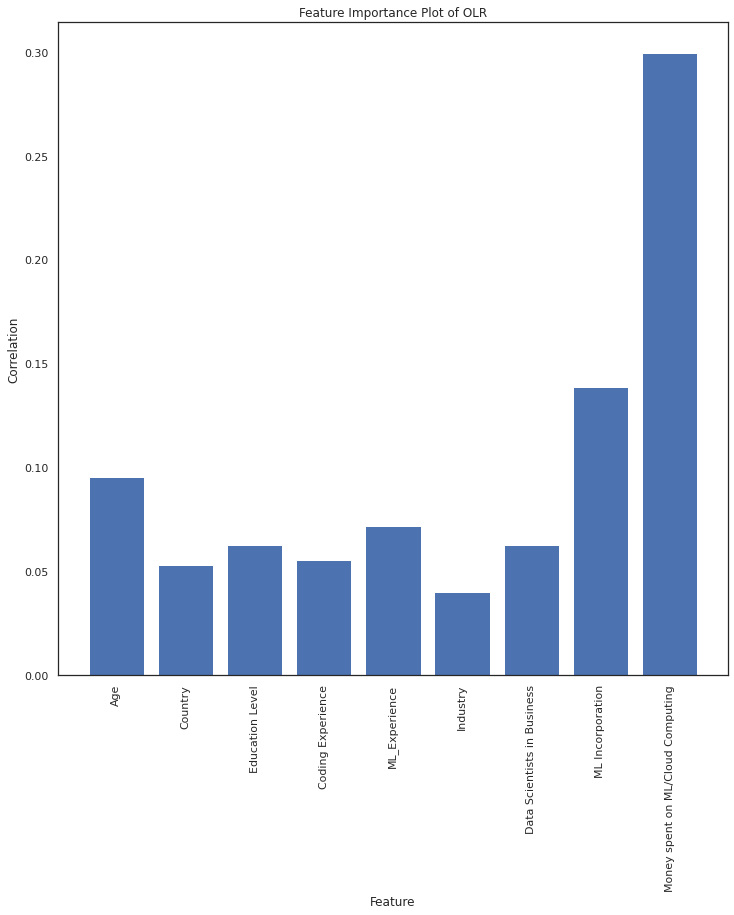

In [169]:
feature01 = feature_imp(X_train01, y_train01)
feature12 = feature_imp(X_train12, y_train12)
feature23 = feature_imp(X_train23, y_train23)
feature34 = feature_imp(X_train34, y_train34)
feature45 = feature_imp(X_train45, y_train45)
feature56 = feature_imp(X_train56, y_train56)
feature67 = feature_imp(X_train67, y_train67)
feature78 = feature_imp(X_train78, y_train78)
feature89 = feature_imp(X_train89, y_train89)
feature910 = feature_imp(X_train910, y_train910)
feature1011 = feature_imp(X_train1011, y_train1011)
feature1112 = feature_imp(X_train1112, y_train1112)
feature1213 = feature_imp(X_train1213, y_train1213)
feature1314 = feature_imp(X_train1314, y_train1314)

feature_concat = pd.concat((feature01, feature12, feature23, feature34, feature45, feature56, feature67, feature78, feature89, feature910,
                            feature1011, feature1112, feature1213, feature1314))

print(feature_concat.mean())
xtickval = selected_var.columns[0:-1].values
plt.bar([x for x in range(len(feature_concat.columns))], feature_concat.mean())
plt.xticks(range(0, len(xtickval)), xtickval, rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Feature Importance Plot of OLR')
plt.show()


5. Testing and Discussion

In [170]:
#Defining the optimal model
opt_LR = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg')

In [171]:
#Running model on test set
prob_0 = []
prob_1 = []
predictions_test = pd.DataFrame()

sal_test = pd.DataFrame()
for i in range(0,14):
    opt_LR = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg')
    opt_LR.fit(train_X[i], train_y[i])
    predictions_test['predict_'+str(i)] = opt_LR.predict(test_X[i])
    sal_test['Salary_Encoded_'+str(i)] = test_y[i]
    prob_0.append(opt_LR.predict_proba(test_X[i])[:,0].mean())
    prob_1.append(opt_LR.predict_proba(test_X[i])[:,1].mean())

#Running model on training set
prob_tr0 = []
prob_tr1 = []
predictions_train = pd.DataFrame()

sal_train = pd.DataFrame()
for i in range(0,14):
    opt_LR = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg')
    opt_LR.fit(train_X[i], train_y[i])
    predictions_train['predict_'+str(i)] = opt_LR.predict(train_X[i])
    sal_train['Salary_Encoded_'+str(i)] = train_y[i]
    prob_tr0.append(opt_LR.predict_proba(train_X[i])[:,0].mean())
    prob_tr1.append(opt_LR.predict_proba(train_X[i])[:,1].mean())

sal_test = sal_test.values.sum(axis=1)
sal_train = sal_train.values.sum(axis=1)
predictions_test['Salary_Encoded'] = sal_test
predictions_train['Salary_Encoded'] = sal_train

Counting the training points

In [172]:
df_count_tr = pd.DataFrame(columns = ['Class_0', 'Class_1', 'Class_2',
'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9',
'Class_10', 'Class_11', 'Class_12', 'Class_13', 'Class_14'])

df_count_tr.at['Count'] = 0
count_tr0 = []
count_tr1 = []
pred_tr_f = []

for i in range(0,13):
    LR = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg')
    LR.fit(train_X[i], train_y[i])
    predict_tr = LR.predict(train_X[i])
    prediction, count = np.unique(predict_tr, return_counts = True)
    count_tr0.append(count[0])
    pred_tr_f.append(predict_tr)
    if i <13:
      count_tr1.append(count[1])

for i in range(0, 13):
    if i == 0:
        df_count_tr['Class_'+ str(i)] = count_tr0[i]

    elif i > 0:
        df_count_tr['Class_'+ str(i)] = count_tr0[i] - count_tr0[i-1]

df_count_tr['Class_13'] = count_tr1[12]

print('Model Output:')
display(df_count_tr)

Model Output:


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
Count,1791,836,567,408,327,264,233,168,136,121,215,157,170,24,0


Counting the testing points

In [173]:
df_count_tt = pd.DataFrame(columns = ['Class_0', 'Class_1', 'Class_2',
'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9',
'Class_10', 'Class_11', 'Class_12', 'Class_13', 'Class_14'])

df_count_tt.at['Count'] = 0
count_tt0 = []
count_tt1 = []
pred_tt_f = []

for i in range(0,13):
    LR = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg')
    LR.fit(train_X[i], train_y[i])
    predict_tt = LR.predict(test_X[i])
    prediction, count = np.unique(predict_tt, return_counts = True)
    count_tt0.append(count[0])
    pred_tt_f.append(predict_tt)
    if i <13:
      count_tt1.append(count[1])

for i in range(0, 13):
    if i == 0:
        df_count_tt['Class_'+ str(i)] = count_tt0[i]

    elif i > 0:
        df_count_tt['Class_'+ str(i)] = count_tt0[i] - count_tt0[i-1]

df_count_tt['Class_13'] = count_tt1[12]

print('Model Output:')
display(df_count_tt)

Model Output:


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
Count,861,422,267,194,184,148,105,83,70,51,106,80,86,12,0


Computing the F1 score for test and train data

In [174]:
train_f1 = np.zeros(14)
test_f1 = np.zeros(14)
for i in range(0,13):
  train_f1[i] = (f1_score(train_y[i], pred_tr_f[i], average = 'binary'))
  test_f1[i] = (f1_score(test_y[i], pred_tt_f[i], average = 'binary'))

print("Train Set F1 Scores: \n", train_f1, "\n", "Test Set F1 Scores: \n", test_f1)

Train Set F1 Scores: 
 [0.79155974 0.74907293 0.70615811 0.66431452 0.63790539 0.6078707
 0.58730159 0.57282982 0.56228571 0.53974616 0.47984267 0.36283186
 0.11428571 0.        ] 
 Test Set F1 Scores: 
 [0.79321254 0.74380165 0.70970537 0.67275495 0.64160097 0.61383285
 0.58396624 0.578      0.55684455 0.52815013 0.46706587 0.37014925
 0.13333333 0.        ]


Outputting the model output for train and test

In [175]:
df_test_mean = pd.DataFrame(columns = ['Class_0', 'Class_1', 'Class_2',
'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9',
'Class_10', 'Class_11', 'Class_12', 'Class_13', 'Class_14'])

df_test_mean.at['Probabilities'] = 0

for i in range(0, 14):
    if i == 0:
        df_test_mean['Class_'+ str(i)] = prob_0[i]

    elif i > 0:
        df_test_mean['Class_'+ str(i)] = prob_0[i] - prob_0[i-1]

df_test_mean['Class_14'] = prob_1[13]

print('Model Test Output:')
display(df_test_mean)

Model Test Output:


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
Probabilities,0.369885,0.09481,0.074312,0.058806,0.05237,0.046443,0.040703,0.034945,0.028452,0.024642,0.049471,0.03425,0.043087,0.028829,0.018995


In [176]:
df_train_mean = pd.DataFrame(columns = ['Class_0', 'Class_1', 'Class_2',
'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9',
'Class_10', 'Class_11', 'Class_12', 'Class_13', 'Class_14'])

df_train_mean.at['Probabilities'] = 0

for i in range(0, 14):
    if i == 0:
        df_train_mean['Class_'+ str(i)] = prob_tr0[i]

    elif i > 0:
        df_train_mean['Class_'+ str(i)] = prob_tr0[i] - prob_tr0[i-1]

df_train_mean['Class_14'] = prob_tr1[13]

print('Model Train Output:')
display(df_train_mean)

Model Train Output:


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
Probabilities,0.374562,0.095071,0.074395,0.058519,0.051689,0.046336,0.040428,0.034521,0.028244,0.024368,0.04892,0.033598,0.04209,0.028244,0.019014


In [177]:
True_tr = Counter(sal_train).most_common()
Train_true = []
Train_true_res = []
for a, b in True_tr:
    Train_true.append(a)
    Train_true_res.append(b)
Train_data_hold = pd.DataFrame()
Train_data_hold['Encoded_Salary_Actual'] = Train_true
Train_data_hold['True_Counts'] = Train_true_res
Train_data_hold.sort_values(by = ['Encoded_Salary_Actual'], inplace = True)

In [178]:
True_tt = Counter(sal_test).most_common()
Test_true = []
Test_true_res = []
for a, b in True_tt:
    Test_true.append(a)
    Test_true_res.append(b)
Test_data_hold = pd.DataFrame()
Test_data_hold['Encoded_Salary_Actual'] = Test_true
Test_data_hold['True_Counts'] = Test_true_res
Test_data_hold.sort_values(by = ['Encoded_Salary_Actual'], inplace = True)

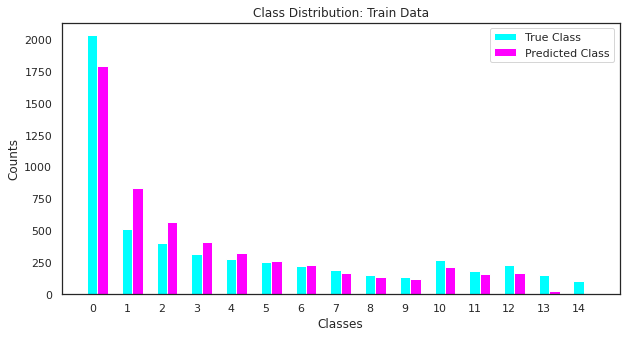

In [179]:
indexs = np.arange(15)
fig,ax= plt.subplots(figsize=(10,5))
rects1 = ax.bar(indexs, Train_data_hold['True_Counts'], width=0.3, color='cyan', label='True Class')
rects2 = ax.bar(indexs+0.3, df_count_tr.iloc[0], width=0.3, color='magenta', label='Predicted Class')
plt.xticks(indexs)
plt.legend();
plt.title("Class Distribution: Train Data");
plt.xlabel('Classes');
plt.ylabel('Counts');

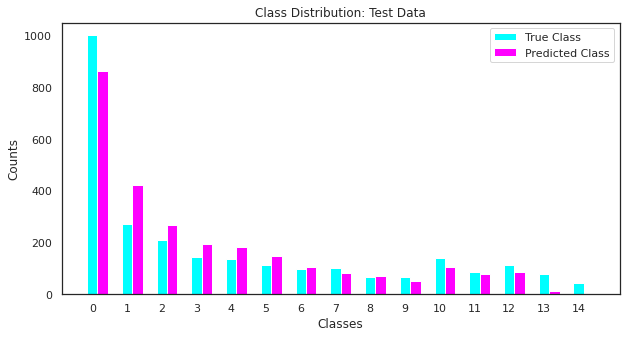

In [180]:
indexs = np.arange(15)
fig,ax= plt.subplots(figsize=(10,5))
rects1 = ax.bar(indexs, Test_data_hold['True_Counts'], width=0.3, color='cyan', label='True Class')
rects2 = ax.bar(indexs+0.3, df_count_tt.iloc[0], width=0.3, color='magenta', label='Predicted Class')
plt.xticks(indexs)
plt.legend();
plt.title("Class Distribution: Test Data");
plt.xlabel('Classes');
plt.ylabel('Counts');